In [1]:
#
# David Laziuk
# Graduate Panorama Stitching From Scratch Assignment
#
#Importing Tools
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
#Just used for visualization, not relevant to solution \/
from jupyterthemes import jtplot
jtplot.style(grid=False)
import qgrid 

In [25]:
#Importing images and extracting one color channel
l_og=cv2.imread('uttower_left.jpg')
l_g=l_og[:,:,0]
r_og=cv2.imread('uttower_right.jpg')
r_g=r_og[:,:,0]

In [3]:
#Defining function to create gaussian filter
def get_gaus(s): 
    #making size scale with sigma
    size=(6*s)+1
    gaus=np.zeros((size,size))
    #iterating through all points in the filter
    for i in range(size):
        for j in range(size):
            x=abs(i-(3*s))
            y=abs(j-(3*s))
            #inputting coordinates and calculating value
            gaus[i,j]=((1/(2*(math.pi)*(s**2)))*(math.e)**(-(((x**2)+(y**2))/(2*s**2))))
    return gaus

In [4]:
#Defining function to add a border to images(extend edge)
def add_border(img,x): 
    ysize=len(img[:,0])
    xsize=len(img[0,:])
    cols=xsize+(2*x)
    rows=ysize+(2*x)
    #blank image with expanded dimensions
    ret=np.zeros(((rows),(cols)))
    #pasting original image in center
    for r in range(ysize):
        for c in range(xsize):
            ret[r+x][c+x]=img[r][c]
    #duplicating each edge row/col across the new border
    for c in range(x):
        ret[:,c]=ret[:,x]
    for c in range(xsize+x,cols):
        ret[:,c]=ret[:,xsize]
    for r in range(x):
        ret[r,:]=ret[x,:]
    for r in range(ysize+x,rows):
        ret[r,:]=ret[ysize,:]
    return ret;

In [5]:
#Defining function to add empty border(for Non-Maximum Supression)
def add_empty_border(img,x): 
    ysize=len(img[:,0])
    xsize=len(img[0,:])
    cols=xsize+(2*x)
    rows=ysize+(2*x)
    #blank image with expanded dimensions
    ret=np.zeros(((rows),(cols)))
    #pasting original image in center
    for r in range(ysize):
        for c in range(xsize):
            ret[r+x][c+x]=img[r][c]
    #adding empty border
    for c in range(x):
        ret[:,c]=ret[:,x]-1000000
    for c in range(xsize+x,cols):
        ret[:,c]=ret[:,xsize]-1000000
    for r in range(x):
        ret[r,:]=ret[x,:]-1000000
    for r in range(ysize+x,rows):
        ret[r,:]=ret[ysize,:]-1000000
    return ret;

In [6]:
#Defining function to pass filters over images
def pass_filter(img,fil,bs): 
    ysize=len(img[:,0])
    xsize=len(img[0,:])
    #extracting original image dimensions
    cols=(xsize-bs*2)
    rows=(ysize-bs*2)
    ret=np.zeros((rows,cols))
    #loop to iterate over every col&row
    for r in range(rows):
        for c in range(cols):
            #reset pixel sum
            val=0
            #determining filter dimensions and iterating across
            #with respect to the original image
            for rf in range((bs*2)+1):
                for cf in range((bs*2)+1):
                    #adding the sum of each pixel under the filter
                    val=val+fil[rf,cf]*(img[r-(rf-bs),c-(cf-bs)])
            #storing sum in pixel of new image
            ret[r,c]=abs(val)
    return ret

In [7]:
#Defining function for non-maximum suppression
def nms(img,win_size): 
    #win_size is #pixels past center -> 3x3nms->win_size=1
    cols=len(img[0,:])
    rows=len(img[:,0])
    ret=np.zeros((rows,cols))
    bor=add_empty_border(img,win_size)
    for r in range(rows):
        for c in range(cols):
            val=-1
            #Finding max val in local area
            for rf in range(-win_size,win_size+1):
                for cf in range(-win_size,win_size+1):
                    tval=bor[r+win_size+rf][c+win_size+cf]
                    if(tval>val):
                        val=tval
            #Only storing if maximum
            if(img[r][c]==val):
                ret[r][c]=val
    return ret

In [8]:
#Defining function to extract patch from img
def extract_patch(img,x,y,patch_size): 
    p=int((patch_size-1)/2)
    patch=np.zeros((patch_size,patch_size))
    pr=0
    pc=0
    for k in range(-p,p+1):
        pc=0
        for l in range(-p,p+1):
            r=x+k+p
            c=y+l+p
            patch[pr,pc]=img[r,c]
            pc+=1
        pr+=1
    return patch

In [26]:
#Smoothing image
sig=1 # Sigma of 1 for gaussian
gaus=get_gaus(sig)
l_g_gaus=pass_filter(add_border(l_g,(sig*3)),gaus,(sig*3))
r_g_gaus=pass_filter(add_border(r_g,(sig*3)),gaus,(sig*3))
l_g_gaus=l_g_gaus.astype(np.uint8)
r_g_gaus=r_g_gaus.astype(np.uint8)
del sig,gaus

In [27]:
#Sobel Filtering
x_sob=np.array([[1,0,-1],[2,0,-2],[1,0,-1]])#vertical sobel filter
y_sob=np.array([[1,2,1],[0,0,0],[-1,-2,-1]])#horizontal sobel filter
#passing each filter
l_dx=pass_filter(add_border(l_g_gaus,1),x_sob,1)
l_dy=pass_filter(add_border(l_g_gaus,1),y_sob,1)
r_dx=pass_filter(add_border(r_g_gaus,1),x_sob,1)
r_dy=pass_filter(add_border(r_g_gaus,1),y_sob,1)
del x_sob,y_sob,l_g_gaus,r_g_gaus

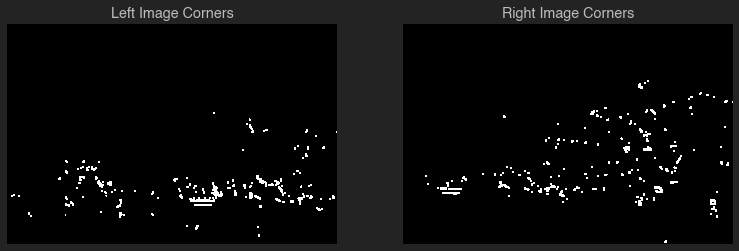

Left Corners: 1001
Right Corners: 1000


In [28]:
#Computing Harris Corner Detector
rows=l_g.shape[0]
cols=l_g.shape[1]
l_cor=np.zeros((rows,cols))
r_cor=np.zeros((rows,cols))
for r in range(rows):
    for c in range(cols):
        dx2=(l_dx[r,c])**2
        dy2=(l_dy[r,c])**2
        l_cor[r,c]=(dx2*dy2)-((.05)*((dx2+dy2)**2))
        dx2=(r_dx[r,c])**2
        dy2=(r_dy[r,c])**2
        r_cor[r,c]=(dx2*dy2)-((.05)*((dx2+dy2)**2))
        
#Keeping top 1000 points
l_ordered=list(np.concatenate(l_cor).flat)
r_ordered=list(np.concatenate(r_cor).flat)
l_ordered=np.sort(l_ordered)
r_ordered=np.sort(r_ordered)
l_ordered=np.flip(l_ordered)
r_ordered=np.flip(r_ordered)
for r in range(rows):
    for c in range(cols):
        if(l_cor[r,c]<l_ordered[999]):
            l_cor[r,c]=0
        if(r_cor[r,c]<r_ordered[999]):
            r_cor[r,c]=0       

plt.figure(figsize=(13,13))
plt.subplot(1,2,1)
plt.imshow(l_cor, cmap='gray',vmin=0,vmax=255)
plt.title("Left Image Corners")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(r_cor, cmap='gray',vmin=0,vmax=255)
plt.title("Right Image Corners")
plt.axis('off')
plt.show()
print("Left Corners: "+str(np.count_nonzero(l_cor)))
print("Right Corners: "+str(np.count_nonzero(r_cor)))
del rows,cols,r,c,dx2,dy2,l_ordered,r_ordered,l_dx,l_dy,r_dx,r_dy

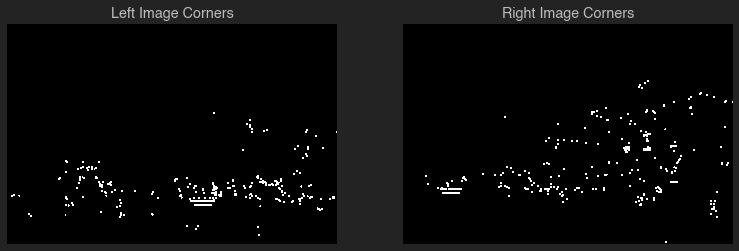

Left Corners: 281
Right Corners: 297


In [29]:
#Non Maximum Supression
l_cor=nms(l_cor,1)
r_cor=nms(r_cor,1)

plt.figure(figsize=(13,13))
plt.subplot(1,2,1)
plt.imshow(l_cor, cmap='gray',vmin=0,vmax=255)
plt.title("Left Image Corners")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(r_cor, cmap='gray',vmin=0,vmax=255)
plt.title("Right Image Corners")
plt.axis('off')
plt.show()
print("Left Corners: "+str(np.count_nonzero(l_cor)))
print("Right Corners: "+str(np.count_nonzero(r_cor)))

In [13]:
#Patch Similarity Testing(SSD)
patch_size=27
p=int((patch_size-1)/2)# num. pixels past center in patch
#Extend images by p to prevent out of bounds
l_ext=add_border(l_g,p)
r_ext=add_border(r_g,p)
#List of correspondences containing score & left/right coords
coresp=np.zeros((np.count_nonzero(l_cor),5))
#Extracting coordinates of all features
l_coords=np.transpose(np.nonzero(l_cor))
r_coords=np.transpose(np.nonzero(r_cor))
#Looping through all features in left image
for i in range(l_coords.shape[0]): 
    #Extracting patch from left
    patchl=extract_patch(l_ext,l_coords[i,0],l_coords[i,1],patch_size)
    #Setting minscore/index
    min_score=999999999
    min_index=-1
    #Looping through all features in right image
    for j in range(r_coords.shape[0]):
        #Extracting patch from right
        patchr=extract_patch(r_ext,r_coords[j,0],r_coords[j,1],patch_size)
        score=0
        #Summing total SSD for all pixels
        for r in range(patch_size):
            for c in range(patch_size):
                score+=(patchr[r,c]-patchl[r,c])**2
        #Updating feature with minimum SSD
        if(score<min_score):
            min_score=score
            min_index=j
    #Storing score & left/right coords
    coresp[i,0]=min_score
    coresp[i,1]=l_coords[i,0]
    coresp[i,2]=l_coords[i,1]
    coresp[i,3]=r_coords[min_index,0]
    coresp[i,4]=r_coords[min_index,1]
#Sorting correspondences based on min SSD
coresp=coresp[coresp[:,0].argsort()]
del patch_size,p,l_ext,r_ext,i,r,c,min_score,min_index,j,score,patchr,patchl

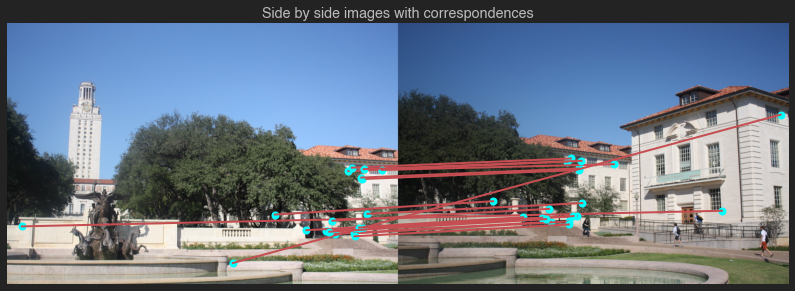

In [14]:
#Plotting Correspondences
lr_img=np.hstack((l_og,r_og))
plt.clf
plt.figure(figsize=(14,15))
plt.imshow(cv2.cvtColor(lr_img,cv2.COLOR_BGR2RGB))
plt.title("Side by side images with correspondences")
plt.axis('off')
for i in range(20):
    xs=np.array((coresp[i,2],coresp[i,4]+1024))
    ys=np.array((coresp[i,1],coresp[i,3]))
    plt.plot(xs[0],ys[0],marker='o',color="cyan",markersize=8)
    plt.plot(xs[1],ys[1],marker='o',color="cyan",markersize=8)
    plt.plot(xs,ys,color="r",linewidth=2)
plt.show()

In [17]:
def compA(corr):
    #Creating matrix A & vector b
    A=np.zeros((1,6))
    b=np.zeros((6,1))
    c=0
    for i in range(corr.shape[0]):
        xl=corr[i,0]
        yl=corr[i,1]
        xr=corr[i,2]
        yr=corr[i,3]
        A=np.vstack([A,(xl,yl,0,0,1,0)])
        A=np.vstack([A,(0,0,xl,yl,0,1)])
        b[c,0]=xr
        b[c+1,0]=yr
        c+=2
    A=A[1:,:]
    #Least Squares to fit
    ata=(A.T).dot(A)
    inv=np.linalg.inv(ata)
    ataa=inv.dot(A.T)
    M=ataa.dot(b)
    #Reformatting
    A=np.zeros((2,2))
    t=np.zeros((2,1))
    A[0,0]=M[0,0]
    A[0,1]=M[1,0]
    A[1,0]=M[2,0]
    A[1,1]=M[3,0]
    t[0,0]=M[4,0]
    t[1,0]=M[5,0]
    return A,t

In [18]:
#Function to count inliers for a Homography
def countIn(A,t,corr,Dthresh):
    #Defining matrix to store transformed points x,y,z
    post=np.zeros((corr.shape[0],2))
    #Calculating point transformation
    for i in range(corr.shape[0]):
        #Retreiving original x&y coords
        xl=corr[i,0]
        yl=corr[i,1]
        xr=corr[i,2]
        yr=corr[i,3]
        #Creating point
        pre=np.array((xl,yl))
        #Dot product of affine matrix with coordinate vector
        post[i]=(A).dot(pre)
        #Individually dividing x&y by z
        post[i,0]=post[i,0]+t[0,0]
        post[i,1]=post[i,1]+t[1,0]
    #Calculating distances
    Nin=0
    avgE=0
    for i in range(post.shape[0]):
        #d=sqrt((x2-x1)^2+(y2-y1)^2)
        dist=np.sqrt(((post[i,0]-corr[i,2])**2)+((post[i,1]-corr[i,3])**2))
        avgE+=dist
        if(dist<=Dthresh):#Count inlier if under threshold
            Nin+=1
    avgE/=int(post.shape[0])#Calculate average feature reprojection error
    return Nin,avgE,post #Returning post only for visualization

In [19]:
#Defining function to calculate reprojected coordinates
def shiftPoint(x,y,A,t):
    pre=np.array((x,y))
    #Dot product of affine matrix with coordinate vector
    post=(A).dot(pre)
    #Individually dividing x&y by z
    post[0]=post[0]+t[0,0]
    post[1]=post[1]+t[1,0]
    return post[0],post[1]

In [20]:
#RANSAC
#Parameters
n=3000
dt=.25
#Dropping SSDval from correspondences, keeping only coords
coresp_copy=coresp[:,1:]
#A1
a1=coresp_copy[:20,:] #Top 20
#A2
a2=np.zeros((30,4))#30 Random
belowTop20=coresp_copy[20:,:]
for i in range(30):
    pos=random.randint(0,belowTop20.shape[0]-1)
    a2[i]=belowTop20[pos]
    belowTop20=np.delete(belowTop20,pos,0)#Deleting Selected Row to prevent repeat
#Adding top 20 to A2
a2=np.vstack((a1,a2))
#RANSAC
for j in range(2):#Repeating Twice for A1&A2
    maxin=0
    for i in range(n):#Repeating n iterations
        if(j==0):
            cs=a1
        else:
            cs=a2
        #Selecting 3 random putative correspondences
        selected_cs=np.zeros((3,4))
        for i in range(3):
            pos=random.randint(0,cs.shape[0]-1)
            selected_cs[i]=cs[pos,:]
            cs=np.delete(cs,pos,0)
        #Calculating affine transformation
        A,t=compA(selected_cs)
        #Testing affine transformation for all correspondences
        Nin,avgE,post=countIn(A,t,coresp_copy,dt)
        #Saving transformation paramaters if new best inlier count
        if(Nin>maxin):
            maxin=Nin
            if(j==0):
                maxinA1=maxin
                bestAvgEa1=avgE
                bestAa1=A
                bestTa1=t
            else:
                maxinA2=maxin
                bestAvgEa2=avgE
                bestAa2=A
                bestTa2=t               
    #Printing Results
print("A1:")
print("Inlier Count: "+str(maxinA1))
print("Average feature reprojection error: "+str(bestAvgEa1))
print("Transformation Matrix:")
print(np.hstack((bestAa1,bestTa1)))
print("")
print("A2:")
print("Inlier Count: "+str(maxinA2))
print("Average feature reprojection error: "+str(bestAvgEa2))
print("Transformation Matrix:")
print(np.hstack((bestAa2,bestTa2)))
print("")

A1:
Inlier Count: 7
Average feature reprojection error: 378.5502876228198
Transformation Matrix:
[[ 9.60479318e-01  3.15704574e-02 -3.73310289e+01]
 [-4.27468602e-02  9.72923148e-01 -4.11602950e+02]]

A2:
Inlier Count: 19
Average feature reprojection error: 231.51887753266706
Transformation Matrix:
[[-5.35607114e-11  1.04627418e-12  4.71000000e+02]
 [-4.80611106e-11  8.58424443e-13  4.83000000e+02]]



In [21]:
#WarpingImage
A=bestAa1
t=bestTa1
#Finding Dimensions of warped Image
TL=shiftPoint(0,0,A,t)
TR=shiftPoint(0,1023,A,t)
BL=shiftPoint(682,0,A,t)
BR=shiftPoint(682,1023,A,t)
dims=np.array((TL,TR,BL,BR))
xmin=int(np.amin(dims[:,0]))
xmax=int(np.amax(dims[:,0]))
ymin=int(np.amin(dims[:,1]))
ymax=int(np.amax(dims[:,1]))
xsize=abs(xmin)+abs(xmax)
ysize=abs(ymin)+abs(ymax)

warp=np.zeros((ysize,xsize,3))
ri=0
ci=0
#Finding intensity values in warped image
Ainv=np.linalg.inv(A)
for i in range(3):
    for r in range(ymin,ymax):
        for c in range(xmin,xmax):
            x,y=shiftPoint(c,r,Ainv,-t)
            if((x<1024)&(x>=0)&(y<683)&(y>=0)):
                val=l_og[int(y),int(x),i]
            else:
                val=0
            warp[ri,ci,i]=val
            ci+=1
        ci=0
        ri+=1
    ri=0

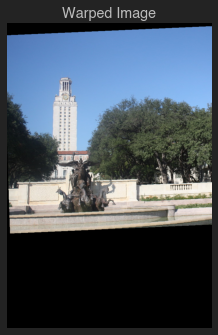

In [22]:
#Displaying warped image
w=warp.astype(np.uint8)
plt.imshow(cv2.cvtColor(w,cv2.COLOR_BGR2RGB))
plt.title("Warped Image")
plt.axis('off')
plt.show()

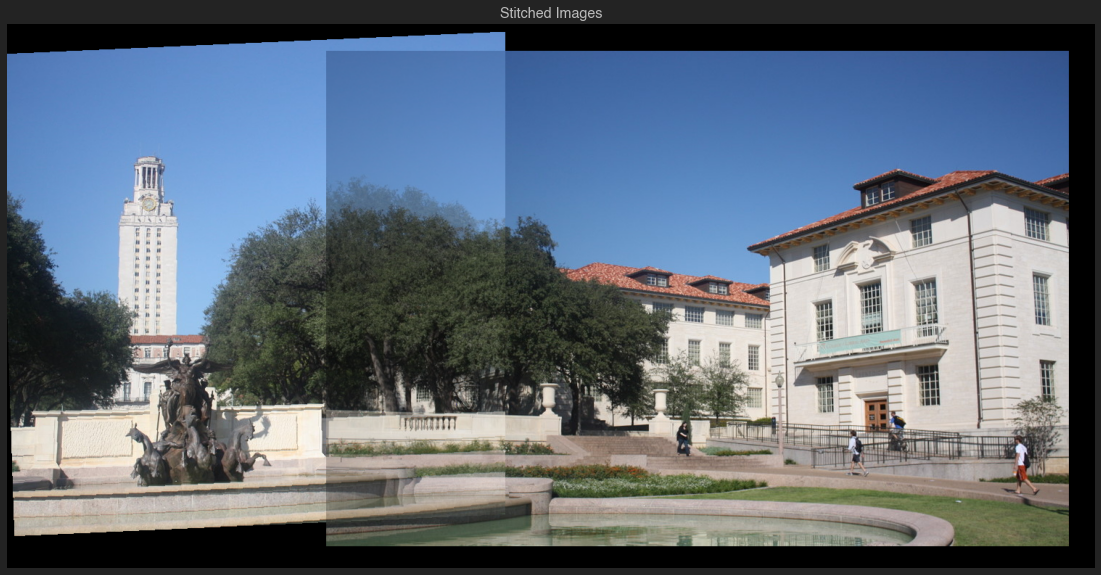

In [23]:
#Stitching Images
res=np.zeros((750,1500,3))
for i in range(3):
    for r in range(750):
        for c in range(warp.shape[1]):
            res[r,c,i]=warp[r,c,i]
    for r in range(r_g.shape[0]):
        for c in range(r_g.shape[1]):
            if(res[r+abs(xmin),c+abs(ymin),i]!=0):
                res[r+abs(xmin),c+abs(ymin),i]/=2
                res[r+abs(xmin),c+abs(ymin),i]+=(r_og[r,c,i])/2
            else:
                res[r+abs(xmin),c+abs(ymin),i]=(r_og[r,c,i])
plt.figure(figsize=(30,10))
res=res.astype(np.uint8)
plt.imshow(cv2.cvtColor(res,cv2.COLOR_BGR2RGB))
plt.title("Stitched Images")
plt.axis('off')
plt.show()